In [26]:
import pandas as pd
import os 
import torch 
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.layers import LSTM, Dense, Embedding, TimeDistributed , Reshape

In [27]:
def load_videos_from_directory(directory_path, target_size=(128, 128)):
    """
    Args:
        directory_path (str): The path to the main directory containing the class subdirectories.
        target_size (tuple): The size to which all extracted frames will be resized (width, height).

    Returns:
        tuple: A tuple containing two NumPy arrays:
               - X: A NumPy array of frame data with shape (num_videos, height, width, channels).
               - Y: A NumPy array of encoded integer labels.
               - class_names: An array of original class names corresponding to the integer labels.
    """
    if not os.path.isdir(directory_path):
        print(f"Error: Directory '{directory_path}' not found.")
        return None, None, None

    X = []  # List to hold the video frame data
    Y_labels = []  # List to hold the original string labels
    
    # Get a list of all subdirectories, which we'll treat as class labels
    class_names = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    
    # Iterate through each class directory
    for class_name in class_names:
        class_path = os.path.join(directory_path, class_name)
        
        # Iterate through each file in the class directory
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            
            # Check if the file is a supported video file
            if file_path.endswith(('.mp4', '.avi', '.mov', '.mkv')):
                try:
                    # Open the video file
                    cap = cv2.VideoCapture(file_path)
                    
                    if not cap.isOpened():
                        print(f"Error: Could not open video file {file_path}")
                        continue
                        
                    # Read the first successful frame
                    ret, frame = cap.read()
                    
                    if ret:
                        # Resize the frame to the target size
                        resized_frame = cv2.resize(frame, target_size)
                        
                        # Append the resized frame data to X
                        # OpenCV reads in BGR format, so we convert to RGB for consistency
                        X.append(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))
                        
                        # Append the class name (label) to Y_labels
                        Y_labels.append(class_name)
                    else:
                        print(f"Could not read a frame from video {file_path}")
                        
                    # Release the video capture object
                    cap.release()
                    
                except Exception as e:
                    print(f"An error occurred with file {file_path}: {e}")
    
    if not X:
        print("No video frames were loaded. Check the directory path and file types.")
        return None, None, None
        
    # Convert lists to NumPy arrays for efficient processing
    X = np.array(X)
    
    # Encode the string labels into numerical integers
    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(Y_labels)

    print(f"Successfully loaded {len(X)} video frames from {len(class_names)} classes.")
    print(f"Shape of X (features): {X.shape}")
    print(f"Shape of Y (labels): {Y.shape}")
    
    return X, Y, label_encoder.classes_



video_directory = "archive"

# IMPORTANT: For this code to work, you must have an 'archive' folder
# with the 'Celeb-real', 'Celeb-synthesis', and 'YouTube-real' subdirectories,
# each containing video files.

# Load the data by extracting and resizing the first frame of each video
X_data, Y_labels, class_names = load_videos_from_directory(video_directory, target_size=(64, 64))

if X_data is not None and Y_labels is not None:
    print("\nLoading complete.")
    print(f"First video frame's shape: {X_data[0].shape}")
    print(f"First video frame's label (encoded): {Y_labels[0]}")
    print(f"Class names: {class_names}")
    print(f"First video frame's class name: {class_names[Y_labels[0]]}")


Successfully loaded 6529 video frames from 3 classes.
Shape of X (features): (6529, 64, 64, 3)
Shape of Y (labels): (6529,)

Loading complete.
First video frame's shape: (64, 64, 3)
First video frame's label (encoded): 0
Class names: ['Celeb-real' 'Celeb-synthesis' 'YouTube-real']
First video frame's class name: Celeb-real


In [32]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM

def load_videos_from_directory(directory_path, target_size=(128, 128)):
    """
    Loads video frames from a structured directory into NumPy arrays for machine learning.

    The directory should be structured as follows:
    main_directory/
    ├── class_a/
    │   ├── video1.mp4
    │   ├── video2.avi
    │   └── ...
    └── class_b/
        ├── video3.mp4
        ├── video4.mov
        └── ...

    Args:
        directory_path (str): The path to the main directory containing the class subdirectories.
        target_size (tuple): The size to which all extracted frames will be resized (width, height).

    Returns:
        tuple: A tuple containing two NumPy arrays:
               - X: A NumPy array of frame data with shape (num_videos, height, width, channels).
               - Y: A NumPy array of encoded integer labels.
               - class_names: An array of original class names corresponding to the integer labels.
    """
    if not os.path.isdir(directory_path):
        print(f"Error: Directory '{directory_path}' not found.")
        return None, None, None

    X = []  # List to hold the video frame data
    Y_labels = []  # List to hold the original string labels
    
    # Get a list of all subdirectories, which we'll treat as class labels
    class_names = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    
    # Iterate through each class directory
    for class_name in class_names:
        class_path = os.path.join(directory_path, class_name)
        
        # Iterate through each file in the class directory
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            
            # Check if the file is a supported video file
            if file_path.endswith(('.mp4', '.avi', '.mov', '.mkv')):
                try:
                    # Open the video file
                    cap = cv2.VideoCapture(file_path)
                    
                    if not cap.isOpened():
                        print(f"Error: Could not open video file {file_path}")
                        continue
                        
                    # Read the first successful frame
                    ret, frame = cap.read()
                    
                    if ret:
                        # Resize the frame to the target size
                        resized_frame = cv2.resize(frame, target_size)
                        
                        # Append the resized frame data to X
                        # OpenCV reads in BGR format, so we convert to RGB for consistency
                        X.append(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))
                        
                        # Append the class name (label) to Y_labels
                        Y_labels.append(class_name)
                    else:
                        print(f"Could not read a frame from video {file_path}")
                        
                    # Release the video capture object
                    cap.release()
                    
                except Exception as e:
                    print(f"An error occurred with file {file_path}: {e}")
    
    if not X:
        print("No video frames were loaded. Check the directory path and file types.")
        return None, None, None
        
    # Convert lists to NumPy arrays for efficient processing
    X = np.array(X)
    
    # Encode the string labels into numerical integers
    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(Y_labels)

    print(f"Successfully loaded {len(X)} video frames from {len(class_names)} classes.")
    print(f"Shape of X (features): {X.shape}")
    print(f"Shape of Y (labels): {Y.shape}")
    
    return X, Y, label_encoder.classes_

def train_and_evaluate_model(X, Y, num_classes):
    """
    Builds, trains, and evaluates a simple CNN model with an LSTM layer.

    Args:
        X (np.ndarray): The feature data (video frames).
        Y (np.ndarray): The label data.
        num_classes (int): The number of unique classes.

    Returns:
        tuple: A tuple containing the trained model and its evaluation history.
    """
    # Normalize the pixel values to be between 0 and 1
    X = X.astype("float32") / 255.0

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    print("\nTraining and evaluating a CNN model with an LSTM layer...")
    print(f"Training set size: {len(X_train)} samples")
    print(f"Testing set size: {len(X_test)} samples")

    # Build a simple CNN model with an LSTM layer
    model = Sequential([
        # CNN layers for feature extraction
        Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Reshape the output of the CNN layers for the LSTM layer
        # The LSTM expects a 3D input: (batch_size, timesteps, features)
        # We will reshape the flattened output to represent a single timestep
        # The correct calculation is based on the output of the previous layer (14x14x64)
        Reshape((1, 14 * 14 * 64)),
        
        # LSTM layer to process the sequence
        LSTM(128, activation='relu'),
        
        # Final dense layers for classification
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    training_training_history = model.fit(X_train, Y_train, epochs=1000, validation_data=(X_test, Y_test))
    
    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(X_test, Y_test)
    print(f"\nModel Evaluation - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    
    return model, history


# --- Example Usage with your parameters ---

# You will need to install the following libraries:
# pip install opencv-python tensorflow scikit-learn

# Path to your main video directory
# Based on your image, this is the 'archive' folder.
video_directory = "archive"

# IMPORTANT: For this code to work, you must have an 'archive' folder
# with the 'Celeb-real', 'Celeb-synthesis', and 'YouTube-real' subdirectories,
# each containing video files.

# Load the data by extracting and resizing the first frame of each video
X_data, Y_labels, class_names = load_videos_from_directory(video_directory, target_size=(64, 64))

if X_data is not None and Y_labels is not None:
    print("\nLoading complete.")
    print(f"First video frame's shape: {X_data[0].shape}")
    print(f"First video frame's label (encoded): {Y_labels[0]}")
    print(f"Class names: {class_names}")
    print(f"First video frame's class name: {class_names[Y_labels[0]]}")
    
    # Train and evaluate the model
    num_classes = len(class_names)
    trained_model, training_history = train_and_evaluate_model(X_data, Y_labels, num_classes)


Successfully loaded 6529 video frames from 3 classes.
Shape of X (features): (6529, 64, 64, 3)
Shape of Y (labels): (6529,)

Loading complete.
First video frame's shape: (64, 64, 3)
First video frame's label (encoded): 0
Class names: ['Celeb-real' 'Celeb-synthesis' 'YouTube-real']
First video frame's class name: Celeb-real

Training and evaluating a CNN model with an LSTM layer...
Training set size: 5223 samples
Testing set size: 1306 samples


/home/waasi/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.8633 - loss: 0.5161 - val_accuracy: 0.8461 - val_loss: 0.6105
Epoch 2/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8681 - loss: 0.4723 - val_accuracy: 0.8461 - val_loss: 0.5139
Epoch 3/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8688 - loss: 0.4456 - val_accuracy: 0.8484 - val_loss: 0.4931
Epoch 4/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8777 - loss: 0.4121 - val_accuracy: 0.8492 - val_loss: 0.5205
Epoch 5/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8868 - loss: 0.3705 - val_accuracy: 0.8560 - val_loss: 0.5281
Epoch 6/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9001 - loss: 0.3313 - val_accuracy: 0.8599 - val_loss: 0.5272
Epoch 7/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9071 - loss: 0.3078 - val_accuracy: 0.8614 - val_loss: 0.5755
Epoch 8/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 

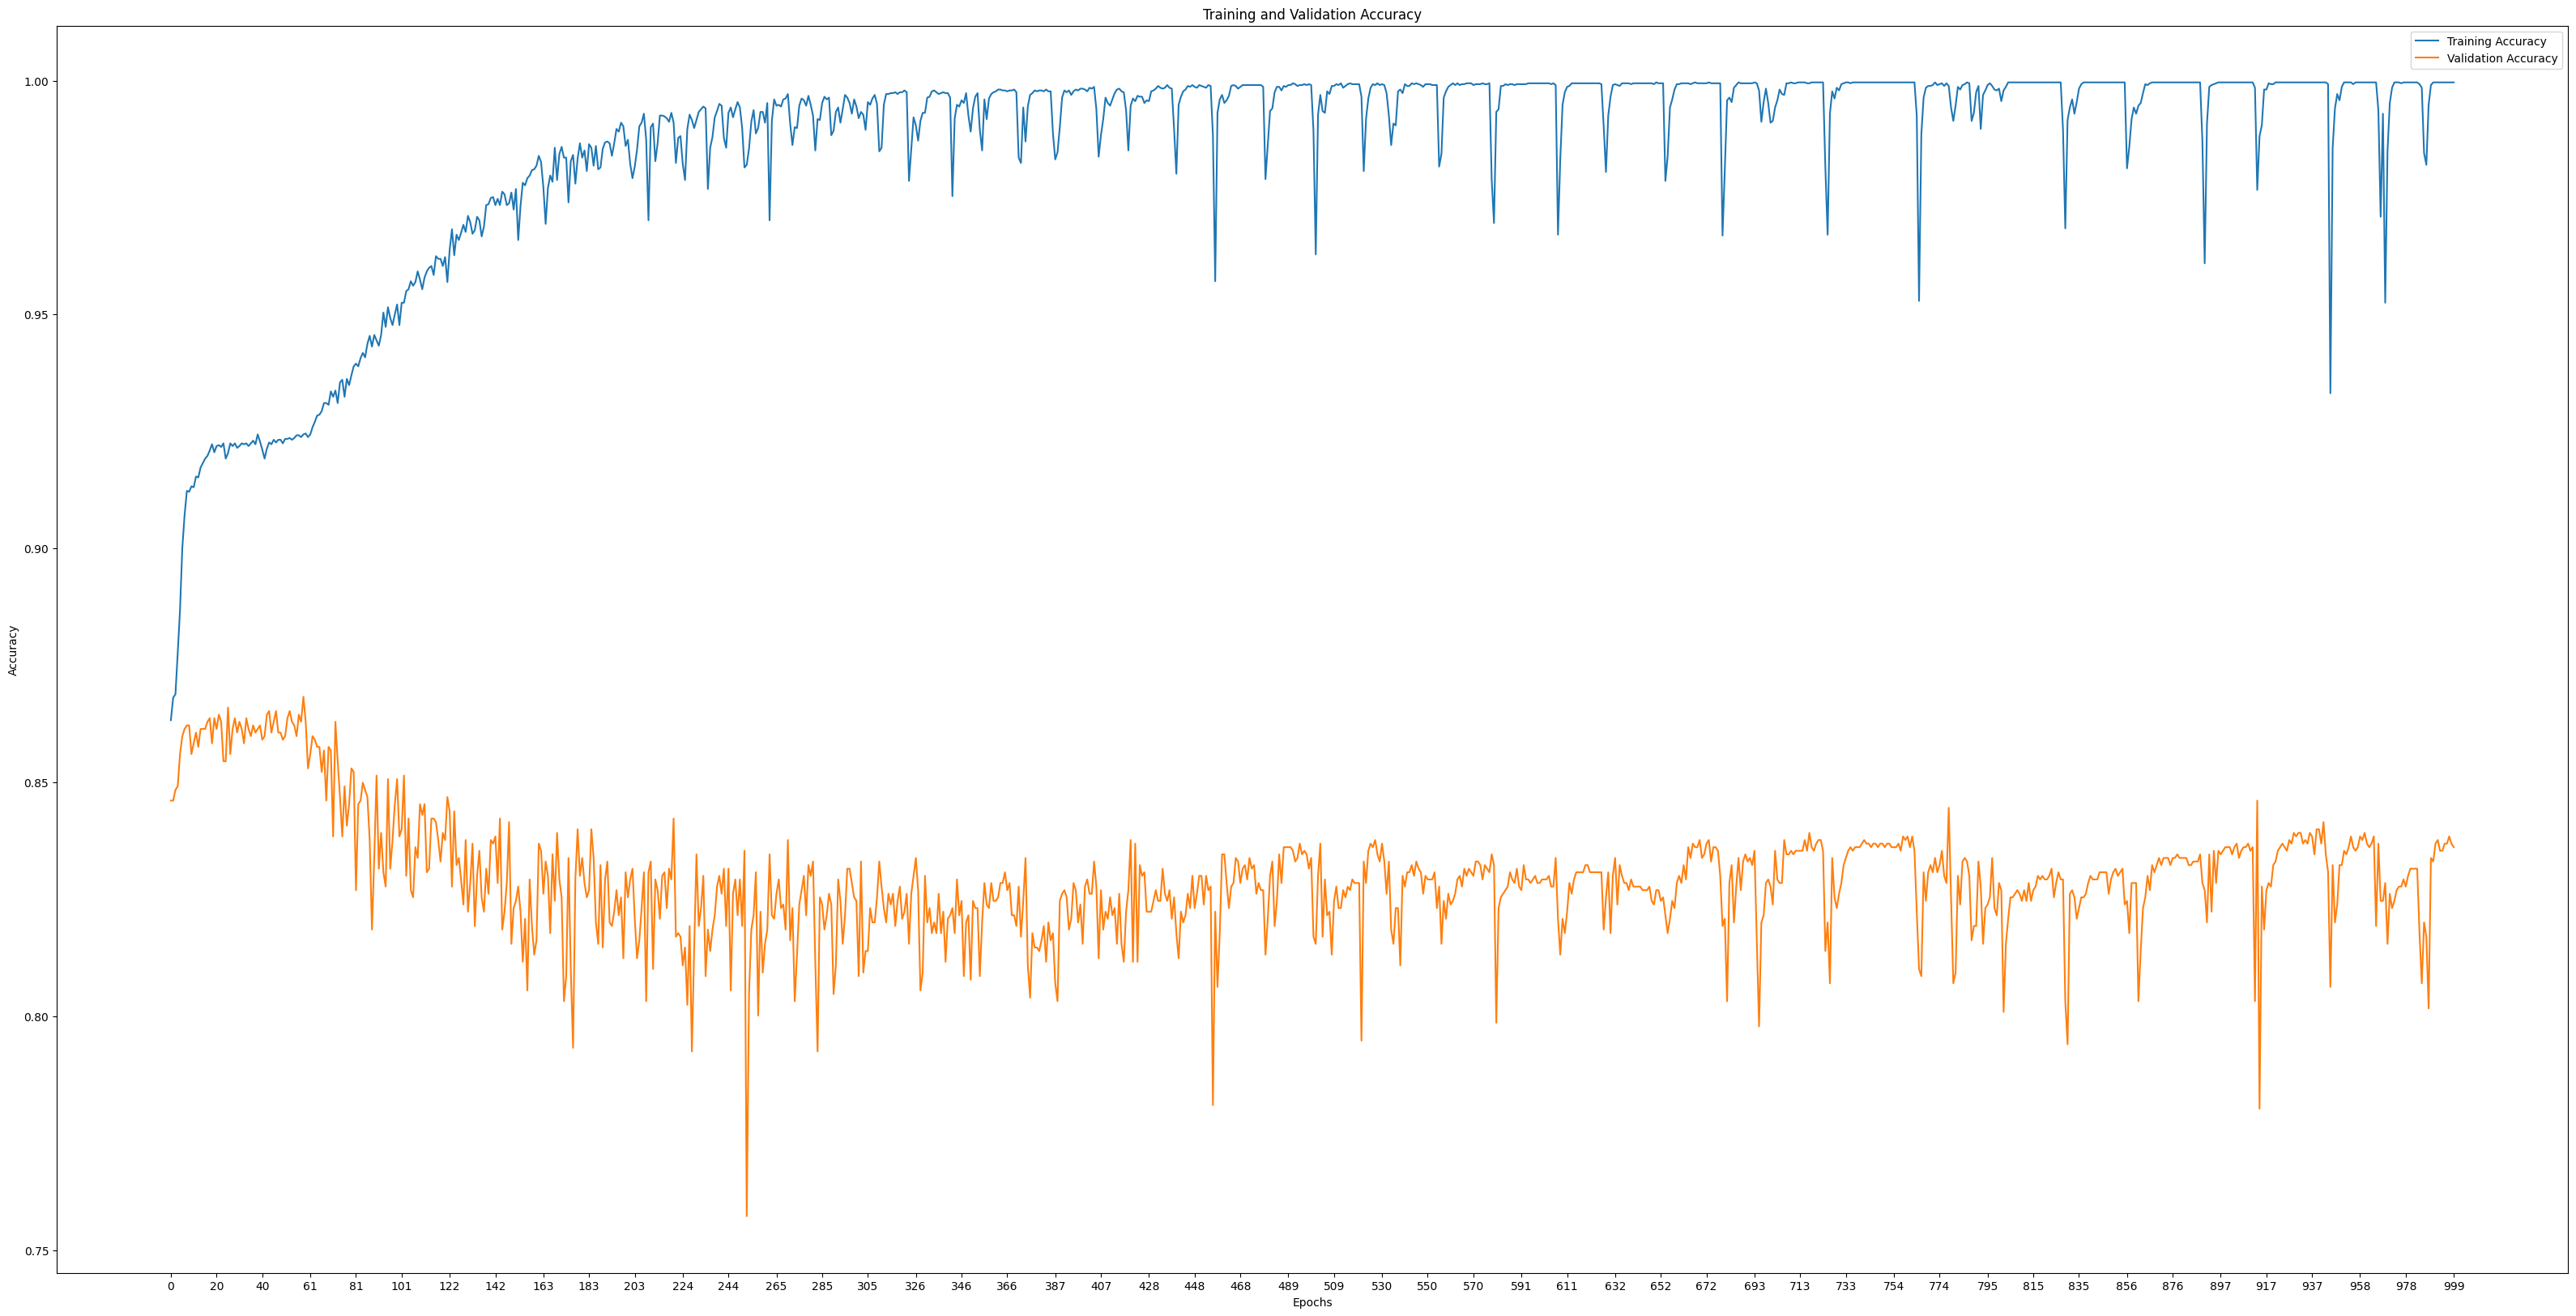

In [36]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()

# Plot the training and validation accuracy
plt.figure(figsize=(40, 20))
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
num_epochs = len(training_history.history['accuracy'])
plt.xticks(np.linspace(0, num_epochs-1, min(num_epochs, 50), dtype=int))
plt.show()



In [ ]:
# Plot the training and validation accuracy with more x-axis ticks for better granularity
plt.figure(figsize=(40, 20))
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Increase the number of x-axis ticks


plt.show()

In [37]:
# Save the entire model to a single HDF5 file
trained_model.save('video_classifier_model.h5')
print("Model saved to video_classifier_model.h5")

Model saved to video_classifier_model.h5


# epoch 50 is the optimal epoch based on the training history
# You can load this model later using:
# from keras.models import load_model
# model = load_model('video_classifier_model.h5')